In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


## Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=2)

client = Client(cluster)
client

2025-03-06 11:54:42,845 - distributed.diskutils - ERROR - Failed to remove '/tmp/dask-scratch-space/worker-ux0yuxtn' (failed in <built-in function open>): [Errno 13] Permission denied: '/tmp/dask-scratch-space/worker-ux0yuxtn'


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.169:35438 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.169:35438,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load in data

In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds = ds.fillna(0.) #remove all NaNs
ds['mask'] = (
    (ds['geolat'] <= -40)
)

# 

grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)

## Boundary Heat Flux Budget
The net heat flux crossing the ocean surface in ocean column grid cell (excluding frazil heat flux) is given by:
$\begin{align}
\sum_{\sigma_2} boundary\_forcing\_heat\_tendency(x, y, \sigma_2, t) &= hflso(x, y, t) + hfsso(x, y, t) \\ &+ rlntds(x, y, t) + heat\_content\_surfwater(x, y, t) \\ &+ \sum_{\sigma_2} rsdoabsorb(x, y, \sigma_2, t)
\end{align}$

Where 
- $hflso$ is the downward latent heat flux
- $hfsso$ is the downward sensible heat flux
- $rlntds$ is the downward longwave heat flux
- $heat\_content\_surfwater$ is heat transfer due to heat content of masstransferred across ocean surface
- $rsdoabsorb$ is the convergence of the penetrative shortwave heat flux

### Aggregate Global Budget

In [6]:
lhs_budget_terms = ["hflso", "hfsso", "rlntds", "rsdoabsorb", "heat_content_surfwater"]
rhs_budget_terms = ["boundary_forcing_heat_tendency"]
budget_terms = lhs_budget_terms + rhs_budget_terms
heat_budget = (ds[budget_terms])
heat_budget_spatial = (heat_budget).sum(["sigma2_l"]).mean("time").compute();
heat_budget = (heat_budget * ds.areacello).sum(["xh", "yh", "sigma2_l"]).compute();


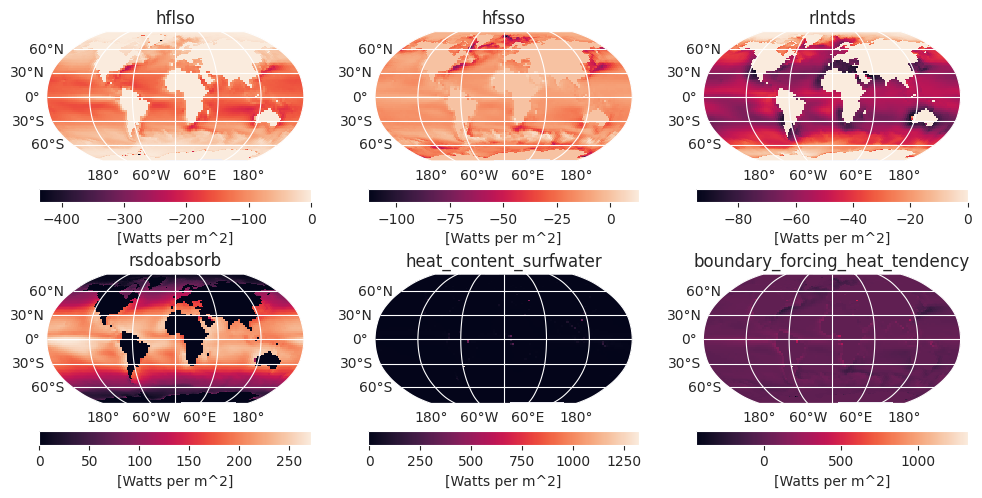

In [8]:
fig, ax = plt.subplots(2, 3, figsize=[10,5], subplot_kw={'projection':ccrs.Robinson()})

for (i, term) in enumerate(budget_terms):
    axes = ax.flatten()[i]
    cm = axes.pcolormesh(heat_budget_spatial['geolon'], heat_budget_spatial['geolat'] , 
                  heat_budget_spatial.isel(exp = 0)[term], 
                  transform = ccrs.PlateCarree())
    axes.set_title(term)
    fig.colorbar(cm, ax = axes, orientation = "horizontal", label = "[Watts per m^2]")
    gl = axes.gridlines(draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
fig.tight_layout()

Text(0, 0.5, '[Terraatts]')

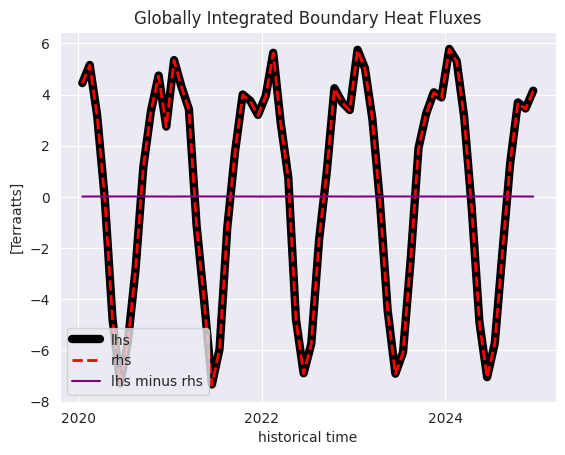

In [9]:
lhs_wb = 1e-15 * heat_budget["boundary_forcing_heat_tendency"].isel(exp = 0)
rhs_wb = 0 * heat_budget["boundary_forcing_heat_tendency"].isel(exp = 0)
for term in lhs_budget_terms:
    rhs_wb += 1e-15 * heat_budget.isel(exp = 0)[term]

fig, ax = plt.subplots()
lhs_wb.plot(label = "lhs", ax = ax, c = "black", linewidth = 6)
rhs_wb.plot(linestyle = "--", label = "rhs", ax = ax, linewidth = 2, c  = "red")
(lhs_wb - rhs_wb).plot(ax = ax, label = "lhs minus rhs", c = "purple")
ax.legend()
ax.set_title("Globally Integrated Boundary Heat Fluxes")
ax.set_ylabel("[Terraatts]")

## Boundary Mass Flux Budget
The net mass flux crossing the ocean surface in ocean grid cell is given by:

$\begin{align}
wfo(x, y, t) &= prlq(x, y, t) + prsn(x, y, t) \\ &+ fsitherm(x, y, t) + friver(x, y, t) \\ &+ ficeberg(x, y, t) + evs(x, y, t) + vprec(x, y, t)
\end{align}$

Where 
- $prlq$ is the mass flux from rain 
- $prsn$ is the mass flux from snow
- $fsitherm$ is mass flux from sea-ice melt
- $friver$ is the mass flux from river runoff 
- $ficeberg$ is the mass flux from icebergs 
- $evs$ is the mass flux from evaporation 

In [14]:
lhs_budget_terms = ["prlq", "prsn", "fsitherm", "friver", "ficeberg", "evs", "vprec"]
rhs_budget_terms = ["wfo"]
budget_terms = lhs_budget_terms + rhs_budget_terms
water_budget = ds[budget_terms]
water_budget_spatial = (water_budget).sum(["sigma2_l"]).mean("time").compute();

water_budget = (water_budget * ds.areacello).sum(["xh", "yh", "sigma2_l"]).compute()

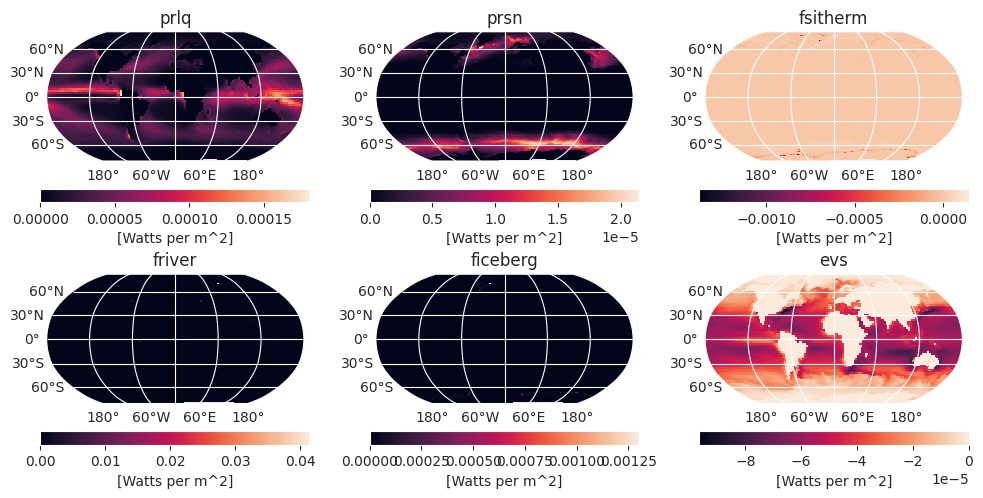

In [15]:
fig, ax = plt.subplots(2, 3, figsize=[10,5], subplot_kw={'projection':ccrs.Robinson()})

for (i, term) in enumerate(lhs_budget_terms[:-1]):
    axes = ax.flatten()[i]
    cm = axes.pcolormesh(water_budget_spatial['geolon'], water_budget_spatial['geolat'] , 
                  water_budget_spatial.isel(exp = 0)[term], 
                  transform = ccrs.PlateCarree())
    axes.set_title(term)
    fig.colorbar(cm, ax = axes, orientation = "horizontal", label = "[Watts per m^2]")
    gl = axes.gridlines(draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
fig.tight_layout()

Text(0, 0.5, '[Terragrams]')

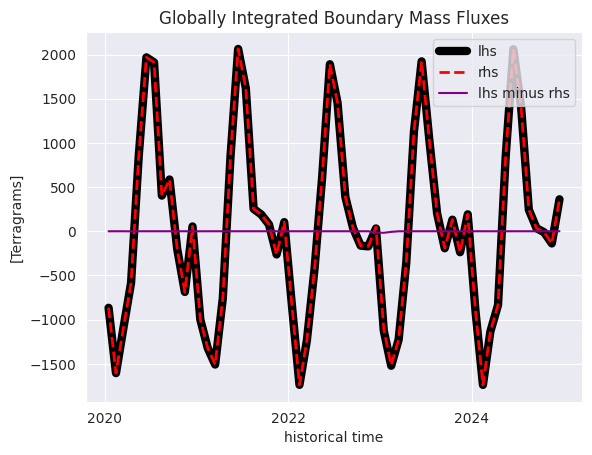

In [16]:
lhs_wb = 1e-9 * 1e3 * water_budget["wfo"].isel(exp = 0)
rhs_wb = 0 * water_budget["wfo"].isel(exp = 0)
for term in lhs_budget_terms:
    rhs_wb += 1e-9 * 1e3 * water_budget.isel(exp = 0)[term]

fig, ax = plt.subplots()
lhs_wb.plot(label = "lhs", ax = ax, c = "black", linewidth = 6)
rhs_wb.plot(linestyle = "--", label = "rhs", ax = ax, linewidth = 2, c  = "red")
(lhs_wb - rhs_wb).plot(ax = ax, label = "lhs minus rhs", c = "purple")
ax.legend()
ax.set_title("Globally Integrated Boundary Mass Fluxes")
ax.set_ylabel("[Terragrams]")

## Creating Southern Ocean Mask


Text(0.5, 1.0, 'Southern Ocean mask')

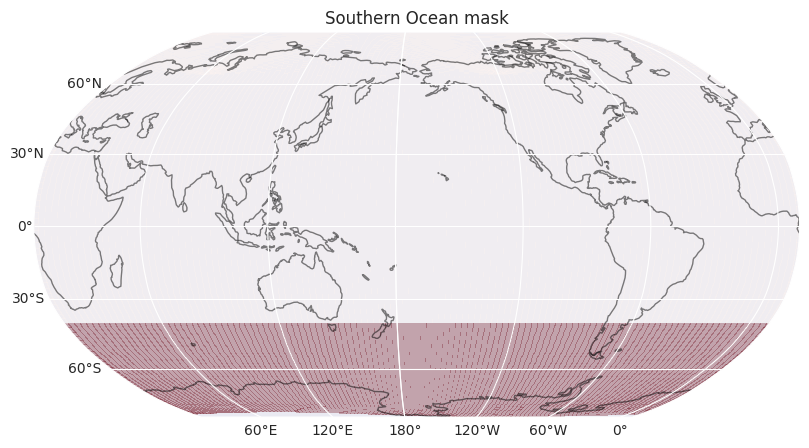

In [17]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
ax.pcolormesh(ds['geolon'], ds['geolat'] , ds['mask'], 
              transform = ccrs.PlateCarree(), cmap = "Reds", alpha = 0.3)
ax.coastlines(alpha = 0.5)
gl = ax.gridlines(draw_labels = True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Southern Ocean mask")

### Define region with ``regionate``

In [18]:
regions = MaskRegions(ds.mask, grid).region_dict
antarctic = regions[0] #there are more in this list if there are multiple contours 
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

## Collect budget terms and mass budget

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_yaml("MOM6_AABW.yaml")
    # budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")

    xbudget.collect_budgets(grid, budgets_dict)

    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        region
    ) #if region not passed, the whole globe is taken
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)

    wmb_decomp = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        region, 
        decompose=["surface_exchange_flux", "nonadvective", "advective"]
    ) #if region not passed, the whole globe is taken
    wmb_decomp.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)

## Collect/plot surface exchange heat flux terms

In [20]:
decomp_heat_vars = ["surface_exchange_flux_nonadvective_longwave_heat", 
                    "surface_exchange_flux_nonadvective_shortwave_heat",
                    "surface_exchange_flux_nonadvective_sensible_heat",
                    "surface_exchange_flux_nonadvective_latent_heat", 
                    "surface_exchange_flux_advective_mass_transfer_heat",
                    "surface_exchange_flux_heat"]

decomp_vars_ds = wmb_decomp.wmt[decomp_heat_vars[:-1]].mean("time").compute() #calculate surface_exchange_flux_heat
lhs = wmb.wmt[decomp_heat_vars[-1]].mean("time").compute() #linear sum terms
rhs = 0 * lhs
for vname in decomp_heat_vars[:-1]:
    rhs += decomp_vars_ds[vname]

Text(0.5, 1.0, 'Surface Exchange Heat Fluxes Comparison')

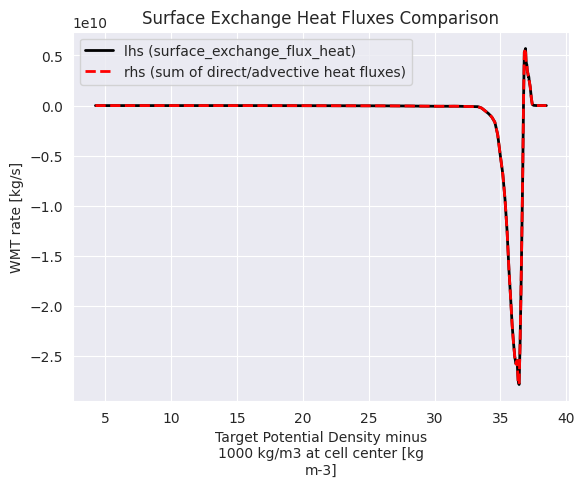

In [24]:
fig, ax = plt.subplots()
lhs.isel(exp = 0).plot(label = "lhs (surface_exchange_flux_heat)", ax = ax, c = "black", linewidth = 2)
rhs.isel(exp = 0).plot(label = "rhs (sum of direct/advective heat fluxes)", ax = ax, linewidth = 2, c  = "red", linestyle = "--")
ax.legend()
ax.set_ylabel("WMT rate [kg/s]")
ax.set_title("Surface Exchange Heat Fluxes Comparison")

## Collect/plot surface exchange salt flux terms

In [22]:
decomp_salt_vars = ["surface_exchange_flux_advective_evaporation_salt", 
                    "surface_exchange_flux_advective_rain_and_ice_salt",
                    "surface_exchange_flux_advective_snow_salt",
                    "surface_exchange_flux_advective_rivers_salt", 
                    "surface_exchange_flux_advective_icebergs_salt",
                    "surface_exchange_flux_advective_virtual_precip_restoring_salt",
                    "surface_exchange_flux_advective_sea_ice_salt",
                   "surface_ocean_flux_advective_negative_rhs_salt"]

lhs = wmb_decomp.wmt[decomp_salt_vars[-1]].mean("time").compute() #calculate surface_ocean_flux_advective_negative_rhs_salt
decomp_vars_ds = wmb_decomp.wmt[decomp_salt_vars[:-1]].mean("time").compute() #linear sum terms

rhs = 0 * lhs
for vname in decomp_salt_vars[:-1]:
    rhs -= decomp_vars_ds[vname]

Text(0.5, 1.0, 'Surface Exchange Salt Fluxes Comparison')

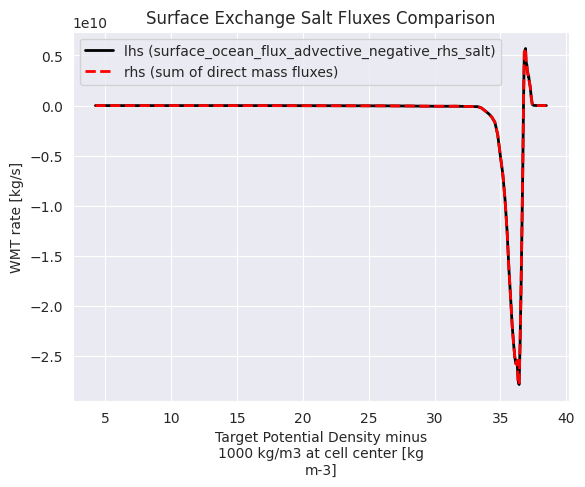

In [23]:
fig, ax = plt.subplots()
lhs.isel(exp = 0).plot(label = "lhs (surface_ocean_flux_advective_negative_rhs_salt)", ax = ax, c = "black", linewidth = 2)
rhs.isel(exp = 0).plot(label = "rhs (sum of direct mass fluxes)", ax = ax, linewidth = 2, c  = "red", linestyle = "--")
ax.legend()
ax.set_ylabel("WMT rate [kg/s]")
ax.set_title("Surface Exchange Salt Fluxes Comparison")